In [1]:
#Construct LSTM using Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import optimizers

print(tf.__version__)
tf.compat.v1.enable_eager_execution()

1.14.0


In [3]:
## This file is used to split data into series of arrays and their corresponding MI task.
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
file = sio.loadmat('CLA-SubjectJ-170508-3St-LRHand-Inter.mat') #replace with .mat file name
header=file['__header__']
version=file['__version__']
glob=file['__globals__']
ans=file['ans']


x=file['x']
o=file['o'][0][0]
data=o['data']
data = np.transpose(data)
print(data)
nS=o['nS'][0][0]
#values of structure seem to be 2D numpy arrays, if originally a scalar in Matlab.
#use [0][0] to get scalar.
print("Number of samples: {numSamples}".format(numSamples=nS))
test=o['id'][0] #id value became a 1D array of size 1 for some reason. use [0] to get value
print("Dataset ID: {id}".format(id=test))

chnames=o['chnames'][:,0] #[:,0] converts from 2D array back to 1D array
print("Channel names: {channelNames}".format(channelNames=chnames))


markers = o['marker']
## The markers are all still individual arrays of size 1x1, so we convert them to an array with single values
markersArray = []
for marker in markers:
    markersArray.append(marker[0])
markersArray = np.asarray(markersArray)

data_df = pd.DataFrame(o['data'])

#For this dataset, the markers are 0, 1, or 2.
# 1 - Left Hand MI, 2 - Right Hand MI, 3 - Passive State, 0 - Rest (???)

[[-18.   -3.6  -6.6 ...  -9.   -7.2  -2.4]
 [-19.2  -0.   -8.4 ...  -8.4 -11.4  -9. ]
 [-12.    1.8  -1.2 ...   2.4   3.6   5.4]
 ...
 [ -6.    5.4   3.  ...   5.4   4.2   3.6]
 [ -8.4   7.2   3.  ...   4.8   6.6   6. ]
 [ -1.2  -1.2  -1.8 ...  -0.   -0.   -0. ]]
Number of samples: 621892
Dataset ID: 201705081338.32BEA9DD
Channel names: [array(['Fp1'], dtype='<U3') array(['Fp2'], dtype='<U3')
 array(['F3'], dtype='<U2') array(['F4'], dtype='<U2')
 array(['C3'], dtype='<U2') array(['C4'], dtype='<U2')
 array(['P3'], dtype='<U2') array(['P4'], dtype='<U2')
 array(['O1'], dtype='<U2') array(['O2'], dtype='<U2')
 array(['A1'], dtype='<U2') array(['A2'], dtype='<U2')
 array(['F7'], dtype='<U2') array(['F8'], dtype='<U2')
 array(['T3'], dtype='<U2') array(['T4'], dtype='<U2')
 array(['T5'], dtype='<U2') array(['T6'], dtype='<U2')
 array(['Fz'], dtype='<U2') array(['Cz'], dtype='<U2')
 array(['Pz'], dtype='<U2')]


# Preprocess raw data for each channel
# Split prepocessed data based on markers

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


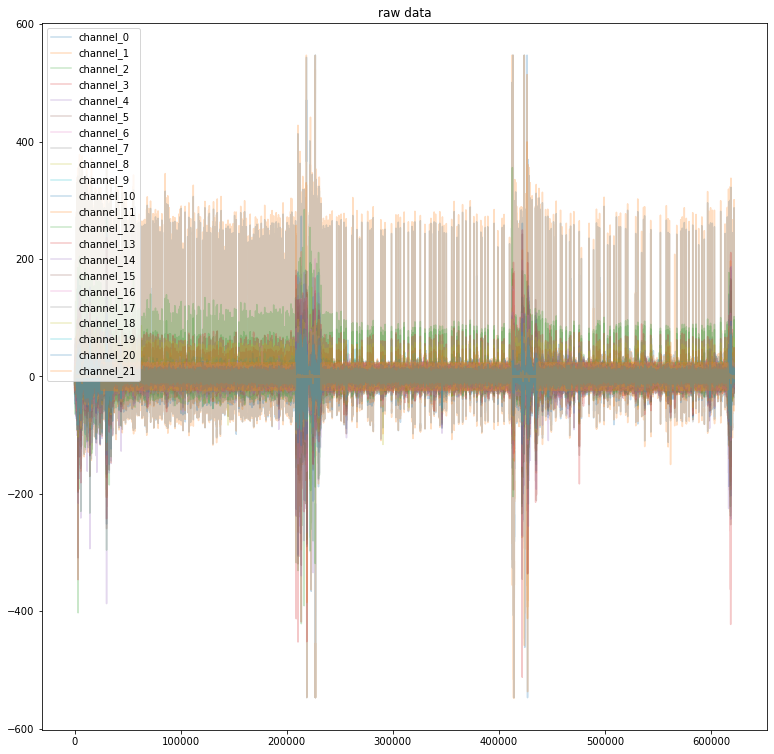

In [4]:
data_df = pd.DataFrame(o['data'])
data_df['marker'] = None
data_df['marker'] = o['marker']

plt.figure(figsize=[13,13])
plt.title('raw data')
for i in range(22):
    plt.plot(data_df[i],alpha=.25,label='channel_{}'.format(i))
plt.legend()
plt.show()
plt.close()


In [5]:
# [:,x] is channel 
#[t,:] is time point

markersArray.shape, o['data'].shape
markersArray = markersArray.reshape((1,len(markersArray.T)))
markersArray.shape,o['data'].shape
o['data'] = np.hstack((o['data'],markersArray.T))



In [6]:
## Find the starting indeces where the marker changes
changeIdxs = np.where(np.transpose(markersArray)[:-1] != np.transpose(markersArray)[1:])[0]
# This function splits data into chunks of -75 and +75 from any marker change
# Will split the data this way after preprocessing it through strategy stated below
def splitDataFrameIntoSmaller(data, changeIdxs): 
    chunks = list()
   
    for i in (changeIdxs):
        chunks.append(data[(i-75):(i+75),:]) # makes point where marker changes middle of time point
    return chunks;





Which channels provide the most information?

Perform PCA on one data chunk 


1. Applying PCA to the data and choose the optimal number of PCs,r, that depends on thepercentage of the total variance that we would like to be explained. In time series signalextraction, usually no more that two or three components are selected.
 
2. Applying any ICA algorithm to the data to extract the ICs.
 
3. Computing the correlation between the PCs and the ICs, and sorting the ICs accordingto the maximum correlation criterion. That is, for each i=1,...m

$$
\max\limits_{i<=j<=m}corr(\hat{s}_{it}^{PCA},\hat{s}_{jt}^{ICA})
$$



Thus, the first IC will be the component that is maximally correlated to the first PC, thesecond IC will have maximum correlation to the second PC, and so on. Once the ICs aresorted, we could select therICs that provides the estimates for the underlying signals.

In [7]:
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from scipy import signal


# Wavelet-BSS via pywt and fastICA 

In [8]:
import pywt


Avoid using Fourier transform because eeg data may not be a infintely repeating sinusoidal wave.  But we may be able to break it into individual wavelets.  A discrete wavelet transform splits up a signal into a low pass sub band (approximation level) and high pass sub band (detail level).  Lin et al used Morlet wavelet transformation for its nonorthogonality.  We will apply the same.

1.) Perform wavelet transformation

2.) Perform Blind Source Separation (BSS) via fastICA, PCA or CCA.  ICA is a blind decomposition that finds maximally statistically independent sources of variance in EEG.

https://sccn.ucsd.edu/~jung/Site/EEG_artifact_removal.html

For ICA, suppose N independent sources and N sensors to record

$
s_1(t),s_2(t),...,s_N(t) \rightarrow \text{signals by N indepdendent sources}
\\
x_1(t),x_2(t),...,x_N(t) \rightarrow \text{observations from N sensors}
\\
x_N(t) = a_{N1}s_1(t) + a_{N2}s_2(t)+...+a_{NN}s_N(t)
\\
=> X = [x_1(t),x_2(t),...,x_N(t)]^T \\
=>S = [s_1(t),s_2(t),...,s_N(t)]^T \\
$

$$
A = \begin{pmatrix}
a_{11} & a_{12} & \ldots & a_{1N}\\
a_{21} & a_{22} & \ldots & a_{2N}\\
\vdots & \vdots & \vdots & \vdots \\
a_{N1} & a_{N2} & \ldots & a_{NN}
\end{pmatrix}
$$

Observations is produced by multiplying signals S with mixing matrix A composed of weights to be found,
$
X=AS 
$
For ICA, we then want to estimate unmixing matrix $W=A^{-1} $

To estimate the source space with unmixing matrix W, we perform;

$\hat{S}=WX$

However, our goal is to reduce the dimensionality of the source space.  ICA separates components based on their amount of gaussian noise, not orthogonality like PCA.  Thus, we separate the components corresponding to the least amount of gaussianility and remove components with high gaussianility as components that fit well to a gaussian bell curve correspond to noise, not signal.  We select these components via kurtosis and sort each dimension in descending order of the corresponding kurtosis value, similar to how we sort eigenvalues in PCA.  Thus, we achieve (N-p) columns of W to produce:
$W_p$

This modified unmixing matrix will allow us to reduce the dimensionality of our dataset by forcing it's psuedoinverse $W_p^{-1}$ and multiplying it with $\hat{S}$ to procure a filtered observation space $\hat{X}$.


For sklearn fastICA, S = fit_transform(X) == X.dot(W) where W is the unmixing matrix.


We then want to sort the independent components based on negentropy.  sklearn's fastICA sorts components based on negentropy which is stronger than kurtosis as it is more resistant to outliers.




Several assumptions are made when taking the ICA, most importantly, we assume the data is relatively non-gaussian, otherwise everything would be sorted into noise.  This is why we couple ICA with PCA and will learn on both sets.  There is also the possibility that the chosen ICs correlate strongly with the PCs suggesting ICs are also orthogonal.

3.) Denoise via conventional linear artifact removal strategies

4.) Inverse Wavelet Transformation

5.)  Inverse Blind Source Separation (BSS) 
For recovery of signal from noisy data via fastICA and PCA

Resource for continuous wavelet transformation

https://pywavelets.readthedocs.io/en/latest/ref/cwt.html

Resource for PCA/ICA decomposition for BSS

https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html



In [9]:
# [:,x] is channel 
#[t,:] is time point
raw = o['data'] #establish raw data
tp,channels = raw.shape

#power spectral density on raw
psd = dict()
sf = 100
time = np.arange(tp)/sf
win = 4*sf
for c_ in range(channels-1):
    freqs,Pxx_den  = signal.welch(raw[:,c_],sf,nperseg=win)
    psd[c_] = (freqs,Pxx_den )




In [10]:
#perform wavelet transformation for each channel
#def wavelet_trans(data):
#    (cA, cD) = pywt.cwt(data,wavelet='morl',scales = 10) 
    #choosen morl for nonorthogonality
    #scale of 10
#    return cA,cD;

def wavelet_trans(data,w):
    data = data.astype(int).tolist()
    cA, cD = pywt.dwt(data,wavelet = w ) 
    cA = np.array(cA)
    cD = np.array(cD)
    
    #choosen morl for nonorthogonality
    #scale of 10
    return cA,cD;

def inverse_wavelet(cA,cD):
    inv_data = pywt.idwt(cA, cD, wavelet='dmey')
    return inv_data;

In [11]:
#WT = np.zeros((tp,channels-1)) #WT is the wavelet transformed data
w = pywt.Wavelet('dmey')
reduced_tp =  int(pywt.dwt_coeff_len(data_len=tp, filter_len=w.dec_len, mode='symmetric'))
WT = np.zeros((reduced_tp,channels-1))

#coeff = np.zeros((22)) #coeffcients from wavelet transformation
coeff = np.zeros((reduced_tp,channels-1))

for c in range(channels-1): #exclude the markers
    A,B = wavelet_trans(raw[:,c],w)
    WT[:,c] = A
    #coeff[c] = B
    coeff[:,c] = B

    
WT.shape
    

(310976, 22)

In [12]:
#perform BSS via fastICA, PCA and CCA on wavelet data
import time
start_time = time.time()
n=19  #general neurology techniques say to keep as many channels as possible
#Essentially, remove the noisiest channel
#The remaining channels will be cleaned 
#
Z = WT  #Define source space as wavelet data
ica = FastICA(n_components = n-1,whiten=True)  #use all components but one


Z_ = ica.fit_transform(Z)   #Estimated Source Space
A_ = ica.mixing_            #Retrieve estimated mixing matrix with reduced dimension


W_p = np.linalg.pinv(A_)    #forced inverse of modified mixing matrix is the unmixing matrix
#X_filt = np.matmul(Z_,A_)





############################################################
pca = PCA(n_components = n-1)
H = pca.fit_transform(Z) #reconstruct signal based on orthogonal components

#########################################################

print("----%s seconds -----" % (time.time() - start_time))

----18.145818948745728 seconds -----


We clean the filtered observation space produced by lowering the dimensions via ICA.

Channel n of a data matrix expressed as 
$$x_n(t) = y_n(t)+f_n(t), \text{ where, } \\ f_n(t) \text{ is the projection of } x_n(t) \text{ on some basis of functions.  } \\y_n(t) \text{ represents a detrended signal.}$$


We want to find $y_n(t)$ for each nth channel

1.)
Remove outliers based on distance of each data point from mean of entire channel time series set.  If the distance/std(data) > 1, then we reject that point and replace it with 0, else the point remains.

2.)  We then detrend the data by subtracting the average of signals over all channels:
$$m(t) = \frac{1}{N}\frac{\sum_n{w_n(t)x_n(t)}}{\sum_nw_n(t)} $$

Afterwards, we transform this cleaned data with inverse ICA, or PCA.

We will then have a data set of lower dimensionality, and less noise.


In [13]:
#Perform standard lineary artifact cleaning of data on ICA, PCA data
#For ICA we clean the estimated source space Z_
#1 outlier detection
def outlier_detection(data):
    w = np.ones((len(data),))
    avg = np.mean(data)
    std = np.std(data)
    ind_above = np.array(1>((data-avg)/std))+1-1
    #remove outliers and replace them with 0
    w[ind_above] = 0
    data[ind_above] = 0
    return w,data;

def robust_referencing(stacks,weights):
    #a glitch on one channel may corrupt the average and contaminate all channels
    #replace x_n(t) with average(x_n(t))
    #---> m(t) = sum[w_n(t)x_n(t)]/sum[w_n(t)]
    #subtract m(t) from all data points in all channels
    col_stack_sums = np.sum(stacks,axis=1)  #sum[x_n]
    col_weight_sums = np.sum(weights,axis=1) #sum[w_n]
    
    #the inclusion of weights leads to Nan data
    #replace Nan with simple 1/N*sum(x_n(t))
    #we can simply rig this by replacing indices of col_weight_sums == 0 with 1
    col_weight_sums[col_weight_sums==0] = 1

    m_t = col_stack_sums*col_weight_sums/col_weight_sums

    
    stacks = [stacks[:,n]-m_t for n in range(stacks.shape[1])]
    stacks = np.array(stacks)
    return stacks;



####create cleaned stack with outlier_detection####
weights = np.zeros((reduced_tp,Z_.shape[1]))
stacks = np.zeros((reduced_tp,Z_.shape[1]))

for c_ in range(Z_.shape[1]):
    inp = Z_[:,c_]
    weights[:,c_],stacks[:,c_] = outlier_detection(inp)
    
stacks = robust_referencing(stacks,weights)

cleaned_Z_ = stacks.reshape((Z_.shape[0],Z_.shape[1]))
Z_.shape,cleaned_Z_.shape
inv_cleaned_Z_ = ica.inverse_transform(cleaned_Z_)
inv_cleaned_Z_

array([[-228.13041653, -237.30844097,  -23.66935503, ...,   10.87401828,
          37.21966616,  -20.96372855],
       [  48.134536  ,  182.00413255,   78.07671108, ...,   -0.4628236 ,
          20.96227019,    5.25192993],
       [  91.41744946,  151.90758   ,   22.22642256, ...,   10.30037614,
          34.95695487,  -13.56748224],
       ...,
       [ 215.95367143,  179.76050789,   59.14564676, ...,  -19.76645013,
         -46.492832  ,    6.84277875],
       [ 232.26552492,   88.8605812 ,   42.19097925, ...,  -36.59212382,
         -85.30929322,   31.30249634],
       [ 326.13817241,  265.37050013,   68.54083987, ...,  -35.44576679,
         -89.42857073,   12.92019797]])

In [14]:
inv_wavelet_cleaned = np.zeros((tp,channels-1))
for c in range(channels-1): #exclude the markers
    cA = inv_cleaned_Z_[:,c]
    cD = coeff[:,c]
    inv_data = inverse_wavelet(cA,cD)
    inv_wavelet_cleaned[:,c] = inv_data

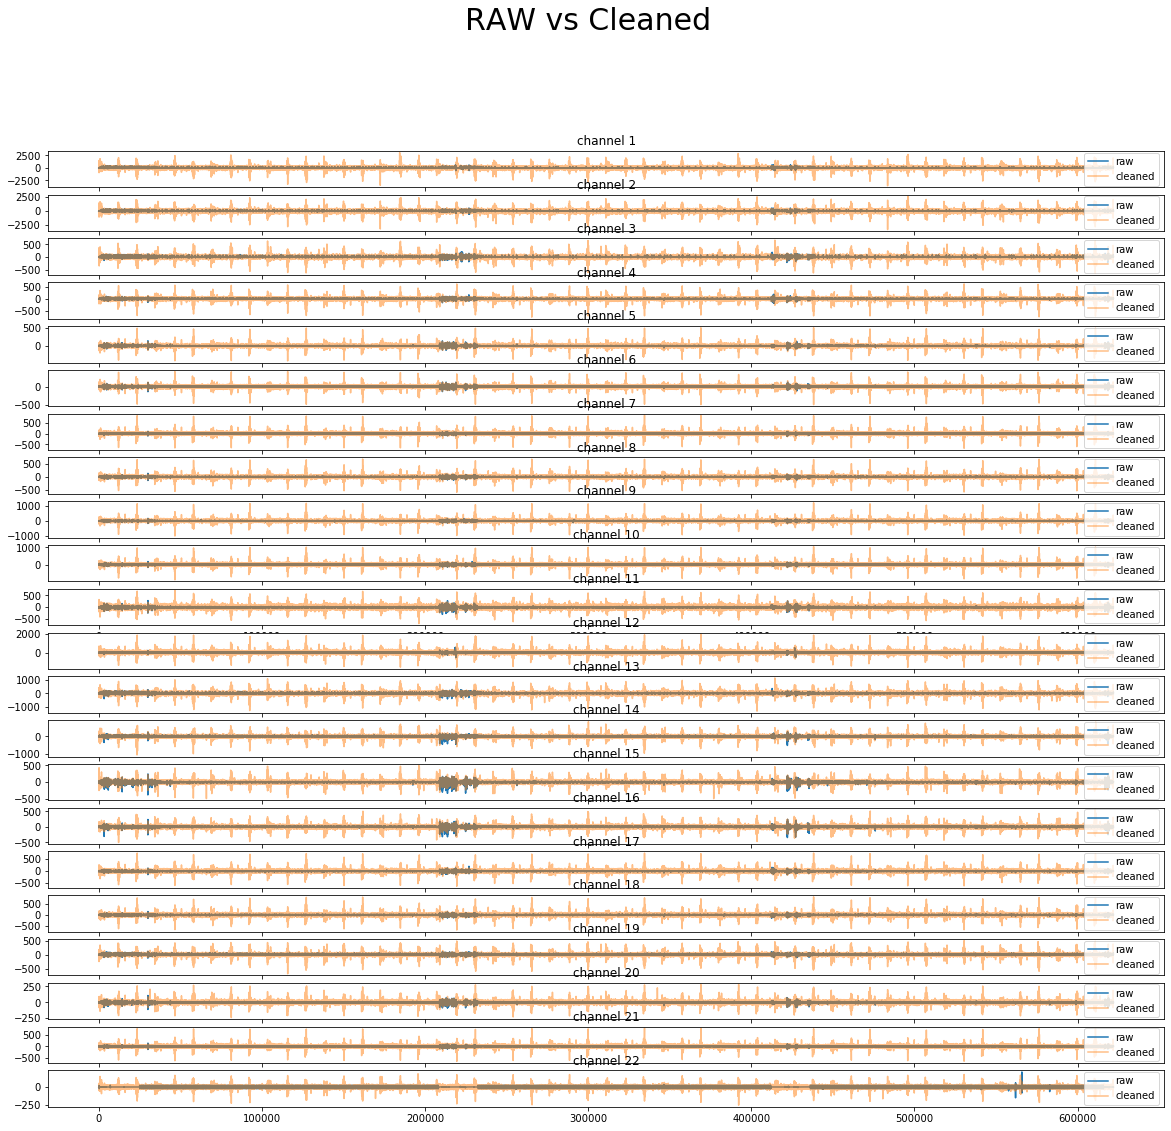

In [15]:
#######X = SA###########
fig = plt.figure()
fig.suptitle('RAW vs Cleaned',fontsize=30)
fig.set_figheight(20)
fig.set_figwidth(20)
for num in range(1,n+4):
    ax = fig.add_subplot(25,1,num)
    ax.set_title('channel {}'.format(num))
    ax.plot(o['data'][:,num-1],label='raw')
    ax.plot(inv_wavelet_cleaned[:,num-1],alpha=0.5,label = 'cleaned')
    ax.legend(loc='right')

plt.show()
plt.close()


In [16]:
inv_wavelet_cleaned = np.hstack((inv_wavelet_cleaned,markersArray.T))
chunks = splitDataFrameIntoSmaller(inv_wavelet_cleaned,changeIdxs)
raw_chunks = splitDataFrameIntoSmaller(raw,changeIdxs)
#These chunks are the cleaned data with markers in the middle of the time series

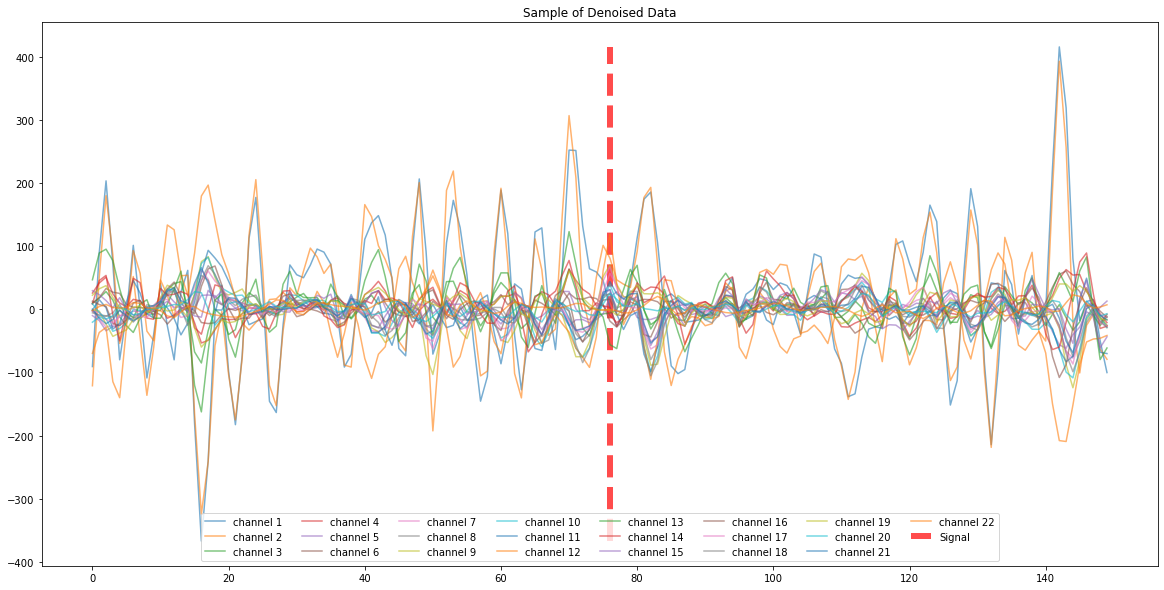

In [17]:

sample = chunks[1]
plt.figure(figsize=[20,10])
plt.title('Sample of Denoised Data')
for i in range(len(sample[1,:])-1):
    plt.plot(sample[:,i],alpha=0.6,label='channel {}'.format(i+1))
mark = sample[:,-1]
c1 = mark[0]
c2 = mark[-1]

ind_ = np.array(np.where(mark !=c1)).tolist()

#plt.plot(sample[:,-1],label = 'marker')
plt.vlines(ind_[0][0],ymin = np.min(sample),ymax = np.max(sample),
           label='Signal',color='red',linewidth = 6,
          linestyles = 'dashed',alpha=0.7)
plt.legend(loc='lower center',ncol=8)

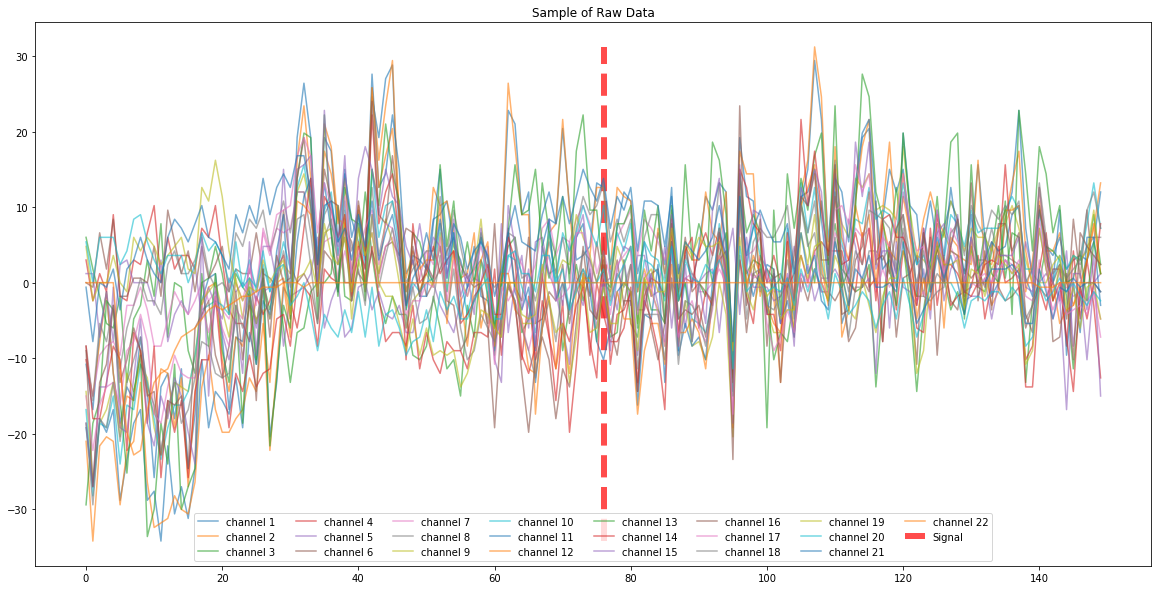

In [18]:

sample = raw_chunks[1]
plt.figure(figsize=[20,10])
plt.title('Sample of Raw Data')
for i in range(len(sample[1,:])-1):
    plt.plot(sample[:,i],alpha=0.6,label='channel {}'.format(i+1))
mark = sample[:,-1]
c1 = mark[0]
c2 = mark[-1]

ind_ = np.array(np.where(mark !=c1)).tolist()

#plt.plot(sample[:,-1],label = 'marker')
plt.vlines(ind_[0][0],ymin = np.min(sample),ymax = np.max(sample),
           label='Signal',color='red',linewidth = 6,
          linestyles = 'dashed',alpha=0.7)
plt.legend(loc='lower center',ncol=8)

# Feed into Neural Network

$
\text{Create labels}
\\0\rightarrow 1 = 1
\\0\rightarrow 2 = 2
\\0\rightarrow 3 = 3
\\1\rightarrow 0 = 4
\\2\rightarrow 0 = 5
\\3\rightarrow 0 = 6
$

In [19]:
#sort chunks into groups based on label set defined above
def labeler(chunk):
    mark = chunk[:,-1]
    c1 = mark[0]
    c2 = mark[-1]
    if c1 == 0 and c2 == 1:
        label = 1
    if c1 == 0 and c2 == 2:
        label = 2
    if c1 == 0 and c2 == 3:
        label = 3
    if c1 == 1 and c2 == 0:
        label = 4
    if c1 == 2 and c2 == 0:
        label = 5
    if c1 == 3 and c2 == 0:
        label = 6
    return label;

def stacker(data):
    label1 = []
    label2 = []
    label3 = []
    label4 = []
    label5 = []
    label6 = []
    for chunk in data:
        label = labeler(chunk)
        #remove the markers from chunk
        chunk = chunk[:,:21]
        if label == 1:
            label1.append(chunk)
        if label == 2:
            label2.append(chunk)
        if label == 3:
            label3.append(chunk)
        if label == 4:
            label4.append(chunk)
        if label == 5:
            label5.append(chunk)
        if label == 6:
            label6.append(chunk)
        
    return label1,label2,label3,label4,label5,label6;

label1,label2,label3,label4,label5,label6 = stacker(chunks)
    

In [20]:
assert(len(label1)+len(label2)+len(label3)+len(label4)+len(label5)+len(label6) == 1800) ,'Does not include all data'

In [21]:
set_lengths = [len(label1),len(label2),len(label3),len(label4),len(label5),len(label6)]
resize = min(set_lengths)
#take top n = resize chunks of data to be learned on so all label sets are same size
label1 = label1[:resize]
label2 = label2[:resize]
label3 = label3[:resize]
label4 = label4[:resize]
label5 = label5[:resize]
label6 = label6[:resize]



In [22]:
label1 = np.asarray(label1)
label2 = np.asarray(label2)
label3 = np.asarray(label3)
label4 = np.asarray(label4)
label5 = np.asarray(label5)
label6 = np.asarray(label6)

In [23]:
label1.shape
#tensor of depth 284 samples, length 150, 21 channels

(284, 150, 21)

In [24]:
target1 = np.tile(np.array([1,0,0,0,0,0]),(284,1))
target2 = np.tile(np.array([0,1,0,0,0,0]),(284,1))
target3 = np.tile(np.array([0,0,1,0,0,0]),(284,1))
target4 = np.tile(np.array([0,0,0,1,0,0]),(284,1))
target5 = np.tile(np.array([0,0,0,0,1,0]),(284,1))
target6 = np.tile(np.array([0,0,0,0,0,1]),(284,1))


In [25]:
#combine all data
all_data = label1
all_targets = target1
for s2 in [label2,label3,label4,label5,label6]:
    all_data = np.vstack((all_data,s2))
for s3 in [target2,target3,target4,target5,target6]:
    all_targets = np.vstack((all_targets,s3))

all_data.shape, all_targets.shape

((1704, 150, 21), (1704, 6))

In [26]:
all_data, all_targets = shuffle(all_data, all_targets, random_state = 0)

data_train, data_test, marker_targets_train, marker_targets_test = train_test_split(all_data,all_targets,
                                                                                   test_size = 0.3, random_state = 1)
marker_targets_train.shape

(1192, 6)

In [27]:
#Reshape the data for time-series processing? -- no need, already correct shape
#((samples, timesteps, numFeatures))
data_trainRe = data_train
data_testRe = data_test

data_trainRe.shape,data_testRe.shape

((1192, 150, 21), (512, 150, 21))

In [28]:
LSTM_EEG = Sequential()
LSTM_EEG.add(LSTM((100),batch_input_shape=(None,data_trainRe.shape[1], data_trainRe.shape[2]), return_sequences=True))
LSTM_EEG.add(LSTM((50), return_sequences=False))
LSTM_EEG.add(Dense((6),activation='sigmoid'))



In [29]:
LSTM_EEG.summary()
sgd = optimizers.SGD(lr=0.05, decay=1e-6, momentum=0.9, nesterov=True)
LSTM_EEG.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 150, 100)          48800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 6)                 306       
Total params: 79,306
Trainable params: 79,306
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = LSTM_EEG.fit(data_train, marker_targets_train, epochs=30,verbose=2, batch_size=16)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/30
1192/1192 - 97s - loss: 0.4727 - acc: 0.8256
Epoch 2/30
1192/1192 - 93s - loss: 0.4480 - acc: 0.8333
Epoch 3/30
1192/1192 - 93s - loss: 0.4453 - acc: 0.8333
Epoch 4/30
1192/1192 - 94s - loss: 0.4423 - acc: 0.8333
Epoch 5/30
1192/1192 - 94s - loss: 0.4388 - acc: 0.8333
Epoch 6/30
1192/1192 - 94s - loss: 0.4364 - acc: 0.8333
Epoch 7/30
1192/1192 - 95s - loss: 0.4348 - acc: 0.8333
Epoch 8/30
1192/1192 - 94s - loss: 0.4312 - acc: 0.8332
Epoch 9/30
1192/1192 - 95s - loss: 0.4291 - acc: 0.8332
Epoch 10/30
1192/1192 - 93s - loss: 0.4288 - acc: 0.8335
Epoch 11/30
1192/1192 - 96s - loss: 0.4258 - acc: 0.8343
Epoch 12/30
1192/1192 - 94s - loss: 0.4236 - acc: 0.8339
Epoch 13/30
1192/1192 - 93s - loss: 0.4204 - acc: 0.8336
Epoch 14/30
1192/1192 - 94s - loss: 0.4216 - acc: 0.8350
Epoch 15/30
1192/1192 - 94s - loss: 0.4166 - acc: 0.8353
Epoch 16/30
1192/1192 - 94s - loss: 0.4088 - acc: 0.8356
Epo

In [34]:
predictionsTest = LSTM_EEG.predict(data_test)


In [35]:
predictionsTest[predictionsTest>0.5] = 1


In [36]:
predictionsTest[predictionsTest<=0.5] = 0

In [39]:
comparisonArrayTest = predictionsTest == marker_targets_test

In [40]:
correctCountTest = 0
for boolValues in comparisonArrayTest:
    if(boolValues[0] & boolValues[1]):
        correctCountTest += 1
falseCountTest = data_test.shape[0] - correctCountTest

predictionsTrain = LSTM_EEG.predict(data_train)
predictionsTrain[predictionsTrain>0.5] = 1;
predictionsTrain[predictionsTrain<=0.5] = 0;
comparisonArrayTrain = predictionsTrain == marker_targets_train;

correctCountTrain = 0
for boolValues in comparisonArrayTrain:
    if(boolValues[0] & boolValues[1]):
        correctCountTrain += 1
falseCountTrain = data_train.shape[0] - correctCountTrain

In [41]:


print("#################################")
print("#################################")
print("Training Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTrain, falseCountTrain, (correctCountTrain*100/data_train.shape[0])))
print("#################################")
print("#################################")
print("Testing Performance:\nCorrect MI Prediction: {}\nIncorrect MI Prediction: {}\nPercent Accuracy: {:.3f}%".format(correctCountTest, falseCountTest, (correctCountTest*100/data_test.shape[0])))
print("#################################")
print("#################################")



#################################
#################################
Training Performance:
Correct MI Prediction: 886
Incorrect MI Prediction: 306
Percent Accuracy: 74.329%
#################################
#################################
Testing Performance:
Correct MI Prediction: 309
Incorrect MI Prediction: 203
Percent Accuracy: 60.352%
#################################
#################################
